## **Bookrecommender using the Goodread Dataset**
## Ironhack Final Project Data Analytics Bootcamp
##### March 2021
###### Sybille Kiziltan


In this notebook I used the Goodreads Dataset to built a recommender system. 

#### Importing all libaries and modules

In [159]:
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import isbnlib
from newspaper import Article
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm
from progressbar import ProgressBar
import re
from scipy.cluster.vq import kmeans, vq
from pylab import plot, show
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import goodreads_api_client as gr
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

In [160]:
import warnings
warnings.filterwarnings("ignore")

### Reading in the data

In [319]:
df = pd.read_csv('books.csv', error_bad_lines = False)

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


In [162]:
df.index = df['bookID']

In [163]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,,
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
5,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
8,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


#### Getting an Idea about how the data looks like

In [17]:
print('Number of unique authors in this dataset:', df['authors'].nunique())
print('Number of total books: {}'.format(df['title'].count()))
print('Number of unique books: {}'.format(df['title'].value_counts().count()))
print('There are ' + str(df['ratings_count'].isin([0]).sum()) +' books with 0 reviews.')

Number of unique authors in this dataset: 6639
Number of total books: 11123
Number of unique books: 10348
There are 80 books with 0 reviews.


In [165]:
#apparently no Nulls!
df["average_rating"].isnull().value_counts()

False    11123
Name: average_rating, dtype: int64

In [320]:
# Creating a table for the missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
publisher,0,0.0
publication_date,0,0.0
text_reviews_count,0,0.0
ratings_count,0,0.0
num_pages,0,0.0
language_code,0,0.0
isbn13,0,0.0
isbn,0,0.0
average_rating,0,0.0
authors,0,0.0


* in the table above we can see that there is no missing data in the data set

In [321]:
#Getting the info about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


In [322]:
#drop NaNs anyway just be sure there is nothing left
df.dropna(0, inplace=True)

In [323]:
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

In [324]:
df.rename(columns={'  num_pages':'total_pages'},inplace=True)

In [325]:
df.head(0)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,total_pages,ratings_count,text_reviews_count,publication_date,publisher


In [326]:
df.shape

(11123, 12)

In [338]:
# Fixing J.K. Rowling rows
df.replace(to_replace='J.K. Rowling/Mary GrandPré', value = 'J.K. Rowling', inplace=True)

In [175]:
# Describe columns with numerical datatypes (float and int)
df.describe()

,bookID,average_rating,isbn13,total_pages,ratings_count,text_reviews_count
count,10648.000000,10648.000000,1.064800e+04,10648.000000,1.064800e+04,10648.000000
mean,21382.013524,3.932653,9.759789e+12,345.496525,1.819256e+04,553.182569
std,13118.048634,0.348860,4.442492e+11,237.481945,1.128816e+05,2617.576960
min,1.000000,0.000000,8.987060e+09,30.000000,0.000000e+00,0.000000
25%,10371.500000,3.770000,9.780345e+12,205.000000,1.170000e+02,9.000000
50%,20387.500000,3.960000,9.780571e+12,304.000000,8.050000e+02,49.000000
75%,32228.000000,4.130000,9.780872e+12,419.000000,5.158000e+03,245.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


#### Processing the data

In [176]:
#scaling the numerical data

In [340]:
ss = StandardScaler()
df2 = ss.fit_transform(df[['average_rating', 'ratings_count', 'text_reviews_count']])

In [341]:
pca = PCA()
pca_data = pca.fit_transform(df2)
new_df = pd.DataFrame(pca_data)
new_df

,0,1,2
0,20.870592,-0.669613,-5.716131
1,21.677568,-0.394782,-5.629299
2,-0.075848,-1.397751,-0.005086
3,24.853344,-0.415254,-4.838562
4,-0.292628,0.539529,-0.037932
...,...,...,...
10948,-0.235206,-0.374655,-0.030962
10949,-0.217990,-0.431012,-0.024771
10950,-0.226126,-0.087407,-0.015094
10951,-0.252654,0.599202,-0.004418


Text(0.5, 1.0, 'Elbow Curve')

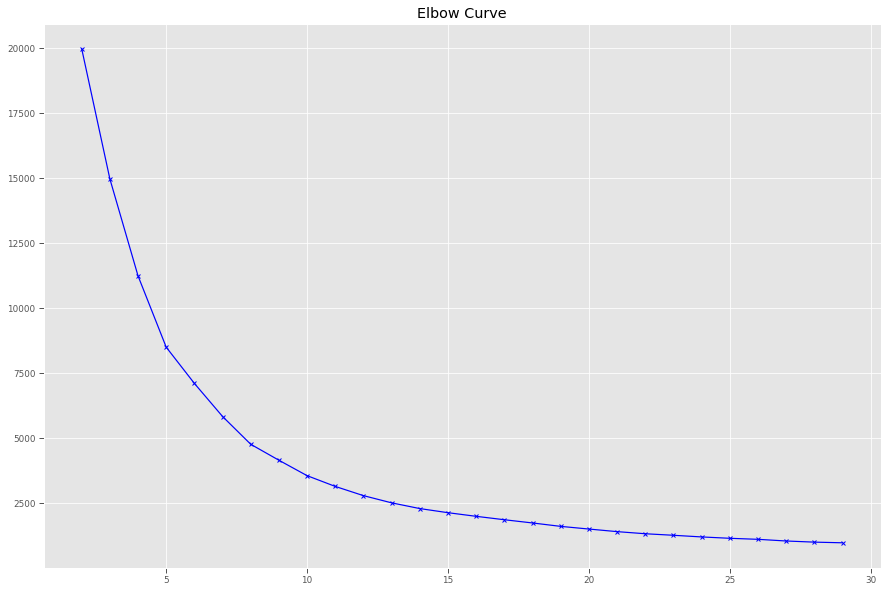

In [344]:
#in the range of 2-30, lets find the best n_clusters 
X = new_df
distortions = []
for k in range(2,30):
    k_means = KMeans(n_clusters = k)
    k_means.fit(X)
    distortions.append(k_means.inertia_)

fig = plt.figure(figsize=(15,10))
plt.plot(range(2,30), distortions, 'bx-')
plt.title("Elbow Curve")

In [ ]:
#########################

In [346]:
# Calculate Silhoutte Score
#
score = silhouette_score(X, k_means.labels_, metric='euclidean')
#
# Print the score
#
print('Silhouetter Score: %.3f' % score)

Silhouetter Score: 0.394


IndexError: index 3 is out of bounds for axis 0 with size 2

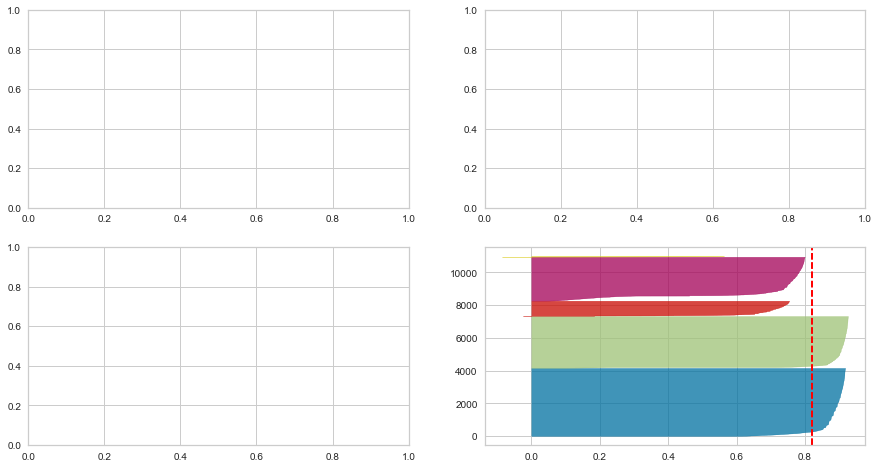

In [363]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [5, 7, 8, 10]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)

In [ ]:
##########################

In [364]:
CENTROIDS = 7

In [365]:
k_means = KMeans(n_clusters = CENTROIDS)
new_df['idx'] = k_means.fit_predict(new_df)
new_df

,0,1,2,idx
0,20.870592,-0.669613,-5.716131,6
1,21.677568,-0.394782,-5.629299,6
2,-0.075848,-1.397751,-0.005086,4
3,24.853344,-0.415254,-4.838562,6
4,-0.292628,0.539529,-0.037932,1
...,...,...,...,...
10948,-0.235206,-0.374655,-0.030962,0
10949,-0.217990,-0.431012,-0.024771,0
10950,-0.226126,-0.087407,-0.015094,0
10951,-0.252654,0.599202,-0.004418,1


* using 7 as our k, we predict what category each book falls into. As you can see the first two rows are the same category, which makes sense because they are both harry potter books

### Visualizations

Text(0.5, 0.92, 'plotting the 3 principle components')

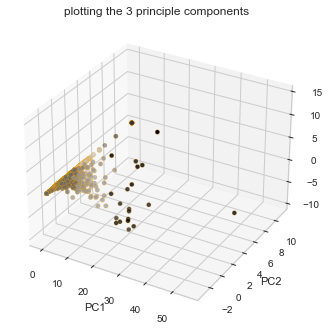

In [366]:
ax3 = plt.axes(projection='3d')
ax3.scatter(new_df[0], new_df[1], new_df[2], edgecolor='orange', c=new_df['idx'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('plotting the 3 principle components')

Text(0.5, 1.0, 'plotting 2 principle components')

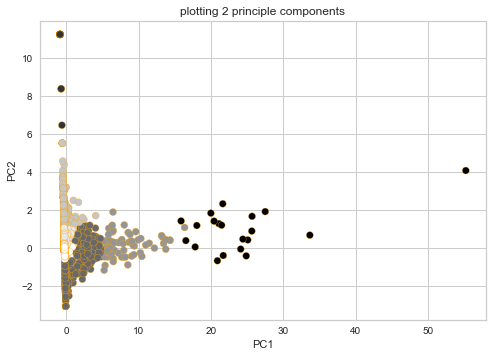

In [367]:
plt.scatter(new_df[0], new_df[1], edgecolor='orange', c=new_df['idx'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('plotting 2 principle components')

Text(0.5, 1.0, 'plotting 2 principle components')

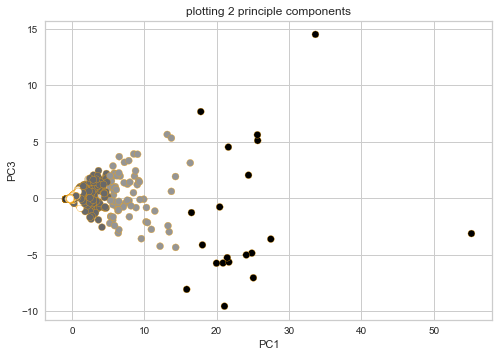

In [368]:
plt.scatter(new_df[0], new_df[2], edgecolor='orange', c=new_df['idx'])
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title('plotting 2 principle components')

Text(0.5, 1.0, 'plotting 2 principle components')

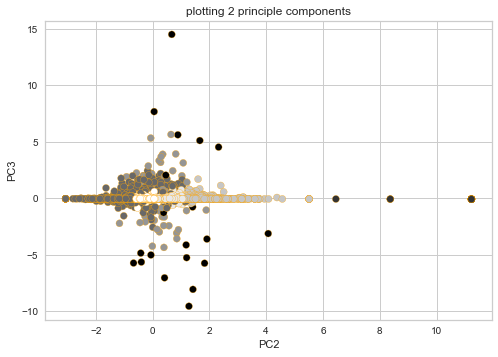

In [369]:
plt.scatter(new_df[1], new_df[2], edgecolor='orange', c=new_df['idx'])
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('plotting 2 principle components')

In [370]:
#outliers
z = np.abs(stats.zscore(new_df[[0,1,2]]))
to_drop = np.unique(np.where(z>=3)[0])
print(to_drop, type(to_drop))

[    0     1     3   227   231   255   273   283   285   288   296   299
   322   342   349   363   398   409   492   499   510   551   558   570
   576   603   608   640   652   655   662   741   760   766   827   870
   882   936   959   980   997  1039  1097  1124  1136  1150  1165  1206
  1237  1265  1368  1381  1382  1388  1392  1397  1419  1424  1429  1437
  1461  1467  1486  1517  1518  1540  1565  1610  1628  1637  1653  1737
  1741  1747  1753  1814  1824  1889  1893  1922  1940  1949  1964  2008
  2056  2062  2064  2078  2109  2132  2147  2211  2375  2386  2392  2480
  2481  2498  2533  2587  2604  2698  2704  2748  2785  2804  2889  2892
  2897  2997  3059  3091  3168  3298  3420  3422  3466  3481  3484  3562
  3565  3566  3662  3836  3999  4048  4072  4079  4088  4162  4175  4331
  4346  4368  4434  4561  4565  4585  4587  4591  4658  4660  4665  4695
  4701  4708  4843  4923  4931  4990  5001  5068  5106  5171  5173  5226
  5309  5434  5465  5541  5542  5543  5564  5710  5

In [371]:
new_df.drop(to_drop, inplace=True)
new_df

,0,1,2,idx
2,-0.075848,-1.397751,-0.005086,4
4,-0.292628,0.539529,-0.037932,1
5,0.270349,-2.267043,0.014750,4
6,2.534915,-1.138081,-0.488527,4
7,-0.056722,-0.823101,0.062472,4
...,...,...,...,...
10948,-0.235206,-0.374655,-0.030962,0
10949,-0.217990,-0.431012,-0.024771,0
10950,-0.226126,-0.087407,-0.015094,0
10951,-0.252654,0.599202,-0.004418,1


In [372]:
from mpl_toolkits.mplot3d import Axes3D

In [416]:
'''
# Set up the axes with gridspec
fig = plt.figure(figsize=(8, 8))
grid = plt.GridSpec(3, 3, hspace=0.2, wspace=0.2)
fig3 = plt.figure()
ax3 = Axes3D(fig3)

pc1_2 = fig.add_subplot(grid[:-1, 1:])
pc0_1 = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharex=pc1_2)
pc0_2 = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharey=pc1_2)

# scatter points on the main axes
ax3.scatter(new_df[0], new_df[1], new_df[2], edgecolor='black', c=new_df['idx'])

# PCs on the attached axes
pc0_1.scatter(new_df[0], new_df[1], edgecolor='black', c=new_df['idx'])
pc0_2.scatter(new_df[0], new_df[2], edgecolor='black', c=new_df['idx'])
pc1_2.scatter(new_df[1], new_df[2], edgecolor='black', c=new_df['idx'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('plotting principle components')
'''

"\n# Set up the axes with gridspec\nfig = plt.figure(figsize=(8, 8))\ngrid = plt.GridSpec(3, 3, hspace=0.2, wspace=0.2)\nfig3 = plt.figure()\nax3 = Axes3D(fig3)\n\npc1_2 = fig.add_subplot(grid[:-1, 1:])\npc0_1 = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharex=pc1_2)\npc0_2 = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharey=pc1_2)\n\n# scatter points on the main axes\nax3.scatter(new_df[0], new_df[1], new_df[2], edgecolor='black', c=new_df['idx'])\n\n# PCs on the attached axes\npc0_1.scatter(new_df[0], new_df[1], edgecolor='black', c=new_df['idx'])\npc0_2.scatter(new_df[0], new_df[2], edgecolor='black', c=new_df['idx'])\npc1_2.scatter(new_df[1], new_df[2], edgecolor='black', c=new_df['idx'])\nplt.xlabel('PC1')\nplt.ylabel('PC2')\nplt.title('plotting principle components')\n"

#### Predictive models 

In [190]:
#creating dummies

In [374]:
df.shape, new_df.shape

((10953, 12), (10702, 4))

In [375]:
df3 = df.copy()
#dropping all the outliers we found in the 2nd z score test for PCs (this took like way too long to figure out)
df3.drop(df3.index[to_drop], inplace=True)
df3.head(2)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,total_pages,ratings_count,text_reviews_count,publication_date,publisher
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
5,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books


In [376]:
df3.shape, new_df.shape

((10702, 12), (10702, 4))

In [377]:
#no NaNs
df3.isnull().values.any(), new_df.isnull().values.any()

(False, False)

In [378]:
for col in df3:
    print(col, df3.isnull()[col].value_counts(), "\n")

bookID False    10702
Name: bookID, dtype: int64 

title False    10702
Name: title, dtype: int64 

authors False    10702
Name: authors, dtype: int64 

average_rating False    10702
Name: average_rating, dtype: int64 

isbn False    10702
Name: isbn, dtype: int64 

isbn13 False    10702
Name: isbn13, dtype: int64 

language_code False    10702
Name: language_code, dtype: int64 

total_pages False    10702
Name: total_pages, dtype: int64 

ratings_count False    10702
Name: ratings_count, dtype: int64 

text_reviews_count False    10702
Name: text_reviews_count, dtype: int64 

publication_date False    10702
Name: publication_date, dtype: int64 

publisher False    10702
Name: publisher, dtype: int64 



In [379]:
df3.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,total_pages,ratings_count,text_reviews_count,publication_date,publisher
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
5,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books
6,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic
8,13,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,4/30/2002,Del Rey Books
9,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,8/3/2004,Crown


In [389]:
#reseting index since we had dropped outliers before
#this may give an error, in which case comment out line 3
#df3 = df3.drop('bookID', axis=0)
df3 = df3.reset_index()
df3 = df3.drop('level_0', axis=1)
df3

,index,bookID,title,authors,average_rating,isbn,isbn13,language_code,total_pages,ratings_count,text_reviews_count,publication_date,publisher
0,0,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
1,1,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books
2,2,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic
3,3,13,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,4/30/2002,Del Rey Books
4,4,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,8/3/2004,Crown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10697,10697,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press
10698,10698,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books
10699,10699,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books
10700,10700,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco


In [390]:
df3 = df3.drop('index', axis=1)

In [391]:
df3.head(0)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,total_pages,ratings_count,text_reviews_count,publication_date,publisher


In [392]:
#reseting index since we had dropped outliers before
new_df = new_df.reset_index()
new_df = new_df.drop("index", axis=1)
new_df

,0,1,2,idx
0,-0.075848,-1.397751,-0.005086,4
1,-0.292628,0.539529,-0.037932,1
2,0.270349,-2.267043,0.014750,4
3,2.534915,-1.138081,-0.488527,4
4,-0.056722,-0.823101,0.062472,4
...,...,...,...,...
10697,-0.235206,-0.374655,-0.030962,0
10698,-0.217990,-0.431012,-0.024771,0
10699,-0.226126,-0.087407,-0.015094,0
10700,-0.252654,0.599202,-0.004418,1


In [393]:
#finally merging the two (PCA'd values with the original df)
df4 = df3.merge(new_df, right_index=True, left_index=True)
df4

,bookID,title,authors,average_rating,isbn,isbn13,language_code,total_pages,ratings_count,text_reviews_count,publication_date,publisher,0,1,2,idx
0,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,-0.075848,-1.397751,-0.005086,4
1,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books,-0.292628,0.539529,-0.037932,1
2,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic,0.270349,-2.267043,0.014750,4
3,13,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,4/30/2002,Del Rey Books,2.534915,-1.138081,-0.488527,4
4,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,8/3/2004,Crown,-0.056722,-0.823101,0.062472,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10697,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press,-0.235206,-0.374655,-0.030962,0
10698,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books,-0.217990,-0.431012,-0.024771,0
10699,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books,-0.226126,-0.087407,-0.015094,0
10700,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco,-0.252654,0.599202,-0.004418,1


In [394]:
#reverifying there are no NaNs
for col in df4:
    print(col, df4.isnull()[col].value_counts(), "\n")

bookID False    10702
Name: bookID, dtype: int64 

title False    10702
Name: title, dtype: int64 

authors False    10702
Name: authors, dtype: int64 

average_rating False    10702
Name: average_rating, dtype: int64 

isbn False    10702
Name: isbn, dtype: int64 

isbn13 False    10702
Name: isbn13, dtype: int64 

language_code False    10702
Name: language_code, dtype: int64 

total_pages False    10702
Name: total_pages, dtype: int64 

ratings_count False    10702
Name: ratings_count, dtype: int64 

text_reviews_count False    10702
Name: text_reviews_count, dtype: int64 

publication_date False    10702
Name: publication_date, dtype: int64 

publisher False    10702
Name: publisher, dtype: int64 

0 False    10702
Name: 0, dtype: int64 

1 False    10702
Name: 1, dtype: int64 

2 False    10702
Name: 2, dtype: int64 

idx False    10702
Name: idx, dtype: int64 



#### Creating dummies

In [395]:
#adding a new col 'rating_between' for future dummy
for i in range(5):
    df4.loc[ (df4['average_rating'] >= i) & (df4['average_rating'] <= i+1), 'rating_between'] = f"between {i} and {i+1}"

In [396]:
#making a dummy col for each rating level
dummy_rating_df = df4['rating_between'].str.get_dummies(sep=",")
dummy_rating_df.head(3)

,between 2 and 3,between 3 and 4,between 4 and 5
0,0,0,1
1,0,1,0
2,0,0,1


In [397]:
#making a dummy col for each language
dummy_language_df = df4['language_code'].str.get_dummies(sep=",")
dummy_language_df.head(3)

,ale,ara,en-CA,en-GB,en-US,eng,enm,fre,ger,gla,...,msa,mul,nl,nor,por,rus,spa,swe,tur,zho
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 ### Weighted ratings instead of actual ratings

In [398]:
def weighted_rating(df):
    v = df['ratings_count']
    R = df['average_rating']
    C = df['average_rating'].mean()
    m = df['ratings_count'].quantile(0.9)
    return (v/(v+m) * R) + (m/(m+v) * C)

In [399]:
#readjusting the weight of "average rating" to be proportional to the quantile of ratings count
df4['weighted_score'] = weighted_rating(df4)

In [400]:
#renaming columns
df4.columns = ['bookID','title','authors','average_rating','isbn','isbn13','language_code',
               '  num_pages','ratings_count','text_reviews_count','publication_date',
               'publisher',"PC1","PC2","PC3",'idx','rating_between','weighted_score']
df4

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,PC1,PC2,PC3,idx,rating_between,weighted_score
0,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,-0.075848,-1.397751,-0.005086,4,between 4 and 5,4.055658
1,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books,-0.292628,0.539529,-0.037932,1,between 3 and 4,3.945603
2,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic,0.270349,-2.267043,0.014750,4,between 4 and 5,4.395550
3,13,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,4/30/2002,Del Rey Books,2.534915,-1.138081,-0.488527,4,between 4 and 5,4.346296
4,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,8/3/2004,Crown,-0.056722,-0.823101,0.062472,4,between 4 and 5,3.997921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10697,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press,-0.235206,-0.374655,-0.030962,0,between 4 and 5,3.946631
10698,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books,-0.217990,-0.431012,-0.024771,0,between 4 and 5,3.950613
10699,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books,-0.226126,-0.087407,-0.015094,0,between 3 and 4,3.946323
10700,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco,-0.252654,0.599202,-0.004418,1,between 3 and 4,3.937813


## Create a model data frame for the model

In [401]:
model_df = pd.concat([dummy_rating_df, dummy_language_df, df4['weighted_score'], df4['average_rating'], df3['ratings_count'], df4['PC1'], df4['PC2'], df4['PC3']], axis=1)
model_df

,between 2 and 3,between 3 and 4,between 4 and 5,ale,ara,en-CA,en-GB,en-US,eng,enm,...,spa,swe,tur,zho,weighted_score,average_rating,ratings_count,PC1,PC2,PC3
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,4.055658,4.42,6333,-0.075848,-1.397751,-0.005086
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,3.945603,3.74,19,-0.292628,0.539529,-0.037932
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,4.395550,4.73,28242,0.270349,-2.267043,0.014750
3,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,4.346296,4.38,249558,2.534915,-1.138081,-0.488527
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,3.997921,4.22,4930,-0.056722,-0.823101,0.062472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10697,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,3.946631,4.06,156,-0.235206,-0.374655,-0.030962
10698,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,3.950613,4.08,783,-0.217990,-0.431012,-0.024771
10699,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,3.946323,3.96,820,-0.226126,-0.087407,-0.015094
10700,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,3.937813,3.72,769,-0.252654,0.599202,-0.004418


In [402]:
min_max_scaler = MinMaxScaler()
model_df_final = min_max_scaler.fit_transform(model_df)
model_df_final_kNN = model_df_final.copy()
model_df_final_DBSCAN = model_df_final.copy()
model_df_final_TSNE = model_df_final.copy()

# KNN

In [403]:
knn_model = neighbors.NearestNeighbors(n_neighbors=CENTROIDS, algorithm='kd_tree')
knn_model.fit(model_df_final_kNN)
distances, indices = knn_model.kneighbors(model_df_final_kNN)

## DBSCAN
* Density-based spatial clustering of applications with noise (DBSCAN) 

In [404]:
DBSCAN_model = DBSCAN(eps=0.2, min_samples=4, algorithm='kd_tree')
DBSCAN_model.fit(model_df_final_DBSCAN)

DBSCAN(algorithm='kd_tree', eps=0.2, min_samples=4)

In [405]:
model_df_final_DBSCAN

array([[0.        , 0.        , 1.        , ..., 0.07790634, 0.24355484,
        0.46377924],
       [0.        , 1.        , 0.        , ..., 0.02940257, 0.57902538,
        0.44724073],
       [0.        , 0.        , 1.        , ..., 0.15536655, 0.09302315,
        0.47376719],
       ...,
       [0.        , 1.        , 0.        , ..., 0.04428234, 0.47046143,
        0.45874026],
       [0.        , 1.        , 0.        , ..., 0.03834675, 0.5893587 ,
        0.46411598],
       [0.        , 1.        , 0.        , ..., 0.03631473, 0.49492944,
        0.44916419]])

In [407]:
from sklearn.cluster import KMeans, DBSCAN

In [408]:
DBSCAN_model = DBSCAN(eps=0.2, min_samples=4, algorithm='kd_tree')
DBSCAN_model.fit(model_df_final_DBSCAN)

DBSCAN(algorithm='kd_tree', eps=0.2, min_samples=4)

In [226]:
#looks like unsupervised ML decides there are 21 genres
clusters = DBSCAN_model.labels_
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18], dtype=int64)

In [227]:
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan', 'deeppink', 
          'olive', 'goldenrod', 'lightcyan', 'navy', 'red', 'orange', 'violet',
           'green', 'yellow', 'cyan', 'magenta', 'black', 'white', 'blue', 'steelblue']
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])

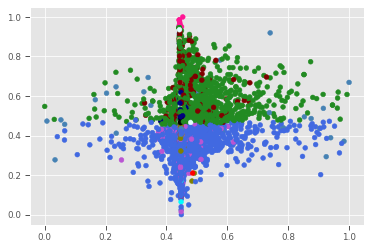

In [228]:
plt.scatter(model_df_final_DBSCAN[:,-1], model_df_final_DBSCAN[:,-2], c=vectorizer(clusters))

## TSNE

In [231]:
from sklearn.manifold import TSNE
TSNE_model = TSNE(n_components=2, learning_rate=150.0, n_iter = 690, verbose=1)
X_embedded = TSNE_model.fit_transform(model_df_final_TSNE)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10405 samples in 1.275s...
[t-SNE] Computed neighbors for 10405 samples in 17.947s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10405
[t-SNE] Computed conditional probabilities for sample 2000 / 10405
[t-SNE] Computed conditional probabilities for sample 3000 / 10405
[t-SNE] Computed conditional probabilities for sample 4000 / 10405
[t-SNE] Computed conditional probabilities for sample 5000 / 10405
[t-SNE] Computed conditional probabilities for sample 6000 / 10405
[t-SNE] Computed conditional probabilities for sample 7000 / 10405
[t-SNE] Computed conditional probabilities for sample 8000 / 10405
[t-SNE] Computed conditional probabilities for sample 9000 / 10405
[t-SNE] Computed conditional probabilities for sample 10000 / 10405
[t-SNE] Computed conditional probabilities for sample 10405 / 10405
[t-SNE] Mean sigma: 0.001226
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.110580
[t-SNE] KL

<AxesSubplot:>

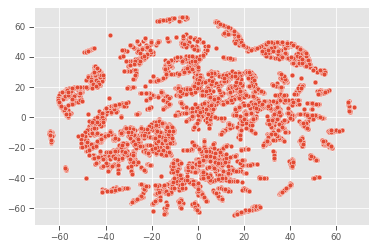

In [232]:
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], legend='full', palette='Spectral')

# Bookrecommendation

In [237]:
all_books_names = list(df4.title.values)
'''
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


 + color.End
print(color.BOLD + 'Hello World !' color.BOLD +)
'''

In [409]:

def get_index_from_name(name):
    print("If you like:\n\n" + name + "\n\nwe recommend you also the following five books:\n")
    return df4[df4["title"]==name].index.tolist()[0]


def get_id_from_partial_name(partial):
    potential_books = dict()
    for name in all_books_names:
        if partial in name:
            potential_books[name] = all_books_names.index(name)
    
    print('You might have meant: ')
    for key in potential_books:
        print(key, potential_books[key], ',')
    print('\n just for fun, lets use ', key, '\n' )
    
    return(potential_books[key])
            
def book_rec(query=None,indx=None):
    if indx:
        for index in indices[indx][1:]:
            print(df4.iloc[index]["title"])
    if query:
        try:
            found_id = get_index_from_name(query)
            for index in indices[found_id][1:]:
                print(df4.iloc[index]["title"])
        except:
            print("We were not able to find this book. Please try another book.")
            found_id = get_id_from_partial_name(query)
            for index in indices[found_id][1:]:
                print(df4.iloc[index]["title"])

In [415]:
book_rec("Selected Speeches and Writings")

If you like:

Selected Speeches and Writings

we recommend you also the following five books:

A Life in Letters
Return of the Straight Dope
Blaming the Victims: Spurious Scholarship and the Palestinian Question
Complete Stories 1892–1898
The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide  #1)
Kaplan & Sadock's Synopsis of Psychiatry: Behavioral Sciences/Clinical Psychiatry


In [414]:
book_rec("Harry Potter")

If you like:

Harry Potter

we recommend you also the following five books:

We were not able to find this book. Please try another book.
You might have meant: 
Harry Potter and the Chamber of Secrets (Harry Potter  #2) 0 ,
Unauthorized Harry Potter Book Seven News: "Half-Blood Prince" Analysis and Speculation 1 ,
Harry Potter Collection (Harry Potter  #1-6) 2 ,
Harry Potter Schoolbooks Box Set: Two Classic Books from the Library of Hogwarts School of Witchcraft and Wizardry 564 ,
J.K. Rowling's Harry Potter Novels: A Reader's Guide 565 ,
Harry Potter and the Half-Blood Prince (Harry Potter  #6) 566 ,
Harry Potter Y La Piedra Filosofal (Harry Potter  #1) 904 ,
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 1126 ,
Looking for God in Harry Potter 3936 ,
Mugglenet.Com's What Will Happen in Harry Potter 7: Who Lives  Who Dies  Who Falls in Love and How Will the Adventure Finally End? 4094 ,
Harry Potter y el misterio del príncipe (Harry Potter  #6) 4095 ,
Harry Potter y la Ord